## Import the Libraries

In [ ]:
pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=59b1be6b59a5666c5c3eae3b7cea88ce21a90bf9c786bc084211ff5aadcc5b53
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [ ]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_self_attention import SeqSelfAttention as AttentionLayer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

## Read the dataset

This dataset consists of reviews of fine foods from Amazon. The data spans a period of more than 10 years, including all ~500,000 reviews up to October 2012. These reviews include product and user information, ratings, plain text review, and summary. It also includes reviews from all other Amazon categories.

We’ll take a sample of 50,000 reviews to reduce the training time of our model.

In [ ]:
import sys
import csv

csv.field_size_limit(sys.maxsize)
data = pd.read_csv("/content/post_prewithno_start.csv", engine='python', on_bad_lines='skip')


## Drop Duplicates and NA values

In [ ]:
data.drop_duplicates(subset=['text'],inplace=True)
data.dropna(axis=0,inplace=True)

## 2. Text Pre-processing

Before we start developing the model, we must first complete some basic preprocessing tasks. Using messy and sloppy text data can be devastating. As a result, in this stage, we will remove all unneeded symbols, characters, and other elements from the text that do not affect the problem's goal.

Here is the dictionary that we will use for expanding the contractions:

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    # lower
    newString = text.lower()
    # remove HTML
    newString = BeautifulSoup(newString, "lxml").text
    # Remove any text inside the parenthesis
    newString = re.sub(r'\([^)]*\)', '', newString)
    # remove double quotes
    newString = re.sub('"','', newString)
    # contraction mapping
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    # remove 's
    newString = re.sub(r"'s\b","",newString)
    # Eliminate punctuations and special characters
    newString = re.sub("[^a-zA-Z]", " ", newString)
    # Remove stopwords
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    # Remove short words
    for i in tokens:
        if len(i)>1:
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [ ]:
# Cleaning the "Text" Column

cleaned_text = []
for t in data['text']:
    cleaned_text.append(text_cleaner(t,0))

Let us look at the first 2 preprocessed reviews

In [ ]:
cleaned_text[:2]

[]

In [ ]:
# Cleaning the "Summary" Column

cleaned_summary = []
for t in data['summary']:
    cleaned_summary.append(text_cleaner(t,1))

Let us look at the first 2 preprocessed summaries

In [ ]:
cleaned_summary[:2]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred']

In [ ]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [ ]:
data['cleaned_text']

,cleaned_text
0,saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition ...
1,kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bi...
2,new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march ...
3,aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental deat...
4,speaking sexual harassment allegations rajkumar hirani sonam kapoor said known hirani many years true metoo movement get derailed metoo movement always believe woman case need reserve judgment add...
...,...
98550,chhavi tyagi apr tuesday indiatoday intoday assam court issued arrest warrant delhi chief minister arvind kejriwal failed appear connection defamation case concerning tweet prime minister narendra...
98563,akshita jain mar wednesday indiatoday intoday india nations offered forgo veto power granted permanent membership reformed security council issue veto important allow veto process council reform s...
98565,tarun khanna mar tuesday indiatoday intoday indian fisherman shot dead monday sri lankan navy coast tamil nadu sri lankan navy opened fire group fishermen fishing danushkodi katchatheevu four fish...
98568,abhishek bansal mar friday indiatoday intoday bombay hc asked centre submit report deaths nuclear scientists india government response details measures taken protect health scientists court said c...


## Drop empty rows

In [ ]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

## Understanding the distribution of the sequences

Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

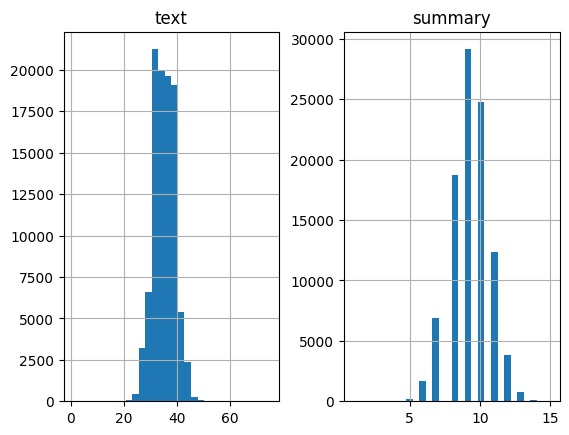

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

**NOTE: We can fix the maximum length of the summary to 8 since that seems to be the majority summary length.**

Let us understand the proportion of the length of summaries below 8

In [ ]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split()) <= 15):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

1.0


**We observe that 94% of the summaries have length below 8. So, we can fix maximum length of summary to 8.**

In [ ]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split()) <= 50):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.9992988659919522


Let us fix the maximum length of review to 30

In [ ]:
max_text_len=50
max_summary_len=15

Let us select the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [ ]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary}) # new dataframe to use

In [ ]:
# add the START and END special tokens at the beginning and end of the summary. Here, We have chosen sostok and eostok as START and END tokens

In [ ]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df.head()

,text,summary
0,saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition ...,sostok upgrad learner switches to career in ml al with salary hike eostok
1,kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bi...,sostok delhi techie wins free food from swiggy for one year on cred eostok
2,new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march ...,sostok new zealand end rohit sharma led india match winning streak eostok
3,aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental deat...,sostok aegon life iterm insurance plan helps customers save tax eostok
4,speaking sexual harassment allegations rajkumar hirani sonam kapoor said known hirani many years true metoo movement get derailed metoo movement always believe woman case need reserve judgment add...,sostok have known hirani for yrs what if metoo claims are not true sonam eostok


## Train-Test Split and Prepare the Tokenizer

In [ ]:
from sklearn.model_selection import train_test_split

x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']), np.array(df['summary']),
                                       test_size=0.1, random_state=0, shuffle=True)

# A tokenizer builds the vocabulary and converts a word sequence to an integer sequence.
# We will now build tokenizers for text and summary.

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

## Rarewords and its Coverage on Reviews column

The threshold is taken as 4 which means word whose count is below 4 is considered as a **rare word**

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:", (cnt/tot_cnt)*100)
print("Total Coverage of rare words:", (freq/tot_freq)*100)

% of rare words in vocabulary: 57.20884734525298
Total Coverage of rare words: 2.036438666470953


In [ ]:
print(cnt),print(tot_cnt)

42108
73604


(None, None)

In [ ]:
print(freq),print(tot_freq)

63541
3120202


(None, None)

NOTE:

* **tot_cnt** gives the size of vocabulary (which means every unique words in the text)

*   **cnt** gives me the no. of rare words whose count falls below threshold

*  **tot_cnt - cnt** gives me the top most common words

Let us define the tokenizer with **top most common words** for reviews.

## Reviews Tokenizer

In [ ]:
# prepare a tokenizer for reviews on training data

x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) # num_words: the maximum number of words to keep, based on word frequency.
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_voc

31497

## Summary Tokenizer

In [ ]:
#prepare a tokenizer for reviews on training data

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

## Rarewords and its Coverage on the summary column

The threshold is taken as 6 which means word whose count is below 6 is considered as a **rare word**

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 64.74375318714941
Total Coverage of rare words: 3.9096769922289956


In [ ]:
print(cnt),print(tot_cnt)

20314
31376


(None, None)

In [ ]:
print(freq),print(tot_freq)

38976
996911


(None, None)

Let us define the tokenizer with **top most common words for summary**.

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:
#deleting the rows that contain only START and END tokens

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# **With attension**

In [ ]:
from tensorflow.keras.layers import AdditiveAttention  # Import AdditiveAttention

latent_dim = 300
embedding_dim = 100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention layer - Changed to AdditiveAttention
attn_layer = AdditiveAttention(name='attention_layer')  # Change this line
attn_out = attn_layer([decoder_outputs, encoder_outputs])  # Adjusted to fit the built-in layer

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 100)        │      3,149,700 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 50, 300),      │        481,200 │ embedding[0][0]        │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 50, 300),      │        721,200 │ lstm[0][0]             │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 100)      │      1,106,300 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 50, 300),      │        721,200 │ lstm_1[0][0]           │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 300),    │        481,200 │ embedding_1[0][0],     │
│                           │ (None, 300), (None,    │                │ lstm_2[0][1],          │
│                           │ 300)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, None, 300)      │            300 │ lstm_3[0][0],          │
│ (AdditiveAttention)       │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 600)      │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 11063)    │      6,648,863 │ concat_layer[0][0]     │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,309,963 (50.77 MB)

 Trainable params: 13,309,963 (50.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([x_tr, y_tr[:,:-1]],
                  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                  epochs=10,
                  callbacks=[es],
                  batch_size=128,
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
                 )

Epoch 1/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 238s 343ms/step - accuracy: 0.3883 - loss: 4.8713 - val_accuracy: 0.4052 - val_loss: 4.3789
Epoch 2/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 267s 350ms/step - accuracy: 0.4054 - loss: 4.2772 - val_accuracy: 0.4269 - val_loss: 3.8909
Epoch 3/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 261s 349ms/step - accuracy: 0.4269 - loss: 3.8119 - val_accuracy: 0.4458 - val_loss: 3.6320
Epoch 4/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 259s 345ms/step - accuracy: 0.4457 - loss: 3.5155 - val_accuracy: 0.4598 - val_loss: 3.4639
Epoch 5/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 261s 343ms/step - accuracy: 0.4607 - loss: 3.2926 - val_accuracy: 0.4715 - val_loss: 3.3483
Epoch 6/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 260s 341ms/step - accuracy: 0.4747 - loss: 3.1012 - val_accuracy: 0.4788 - val_loss: 3.2589
Epoch 7/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 263s 343ms/step - accuracy: 0.4866 - loss: 2.9408 - val_accuracy: 0.4855 - val_loss: 3.1965
Epoch 8/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 259s 339ms/step - accuracy: 0.4975 -

## Understanding the Diagnostic plot

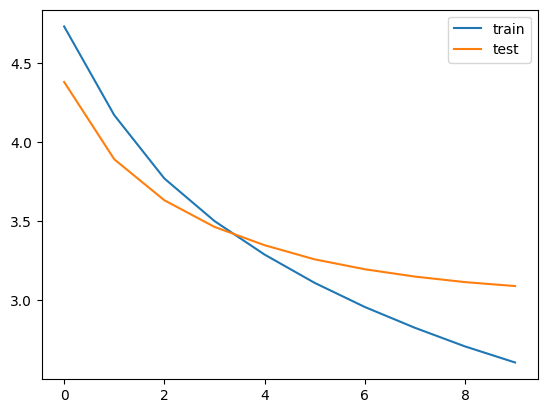

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [ ]:
from tensorflow.keras.models import load_model

# Load the full model
model2 = load_model('encoder_decoder_model.h5', custom_objects={'AdditiveAttention': AdditiveAttention})


In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

## Inference

Set up the inference for the encoder and decoder:

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(None, latent_dim))  # Changed to None for variable-length sequences

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention inference - Updated to correctly provide inputs
attn_layer = AdditiveAttention(name='attention_layer')
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])  # Adjusted the input order

# Concatenate attention output with decoder outputs
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate probability distribution over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)

# Summary of the decoder model
decoder_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 100)      │      1,106,300 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 300)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 300)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 300),    │        481,200 │ embedding_1[1][0],     │
│                           │ (None, 300), (None,    │                │ input_layer_2[0][0],   │
│                           │ 300)]                  │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, None, 300)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, None, 300)      │            300 │ lstm_3[1][0],          │
│ (AdditiveAttention)       │                        │                │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat (Concatenate)      │ (None, None, 600)      │              0 │ lstm_3[1][0],          │
│                           │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 11063)    │      6,648,863 │ concat[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,236,663 (31.42 MB)

 Trainable params: 8,236,663 (31.42 MB)

 Non-trainable params: 0 (0.00 B)

We are defining a function below which is the implementation of the inference process

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Here are a few summaries generated by the model:

In [ ]:
for i in range(0, 10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: inflation venezuela new currency introduced three weeks ago hit price cup coffee caracas doubled bolivars since introduction according bloomberg cafe con index president nicol maduro removed five bolivar price new bolivars equal old bolivars 
Original summary: inflation in venezuela week old currency hits 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted summary:  india to be in the world cup


Review: search giant google added new search navigation tab called finance desktop mobile web tab gives easier access financial information related news based users interests also lets users see performance information stocks users choose follow shows recommendations stocks indices follow

Finally, Our model is able to generate a meaningful summary based on the context present in the text.

In [ ]:
!pip install rouge


Sample 1:
ROUGE-1: 0.13, ROUGE-2: 0.00, ROUGE-L: 0.13, BLEU: 0.00

Sample 2:
ROUGE-1: 0.00, ROUGE-2: 0.00, ROUGE-L: 0.00, BLEU: 0.00

Sample 3:
ROUGE-1: 0.00, ROUGE-2: 0.00, ROUGE-L: 0.00, BLEU: 0.00

Sample 4:
ROUGE-1: 0.14, ROUGE-2: 0.00, ROUGE-L: 0.14, BLEU: 0.00

Sample 5:
ROUGE-1: 0.00, ROUGE-2: 0.00, ROUGE-L: 0.00, BLEU: 0.00

Sample 6:
ROUGE-1: 0.12, ROUGE-2: 0.00, ROUGE-L: 0.12, BLEU: 0.00

Sample 7:
ROUGE-1: 0.11, ROUGE-2: 0.00, ROUGE-L: 0.11, BLEU: 0.00

Sample 8:
ROUGE-1: 0.00, ROUGE-2: 0.00, ROUGE-L: 0.00, BLEU: 0.00

Sample 9:
ROUGE-1: 0.11, ROUGE-2: 0.00, ROUGE-L: 0.11, BLEU: 0.00

Sample 10:
ROUGE-1: 0.22, ROUGE-2: 0.00, ROUGE-L: 0.22, BLEU: 0.00

Sample 11:
ROUGE-1: 0.00, ROUGE-2: 0.00, ROUGE-L: 0.00, BLEU: 0.00

Sample 12:
ROUGE-1: 0.00, ROUGE-2: 0.00, ROUGE-L: 0.00, BLEU: 0.00

Sample 13:
ROUGE-1: 0.11, ROUGE-2: 0.00, ROUGE-L: 0.11, BLEU: 0.00

Sample 14:
ROUGE-1: 0.12, ROUGE-2: 0.00, ROUGE-L: 0.12, BLEU: 0.00

Sample 15:
ROUGE-1: 0.15, ROUGE-2: 0.00, ROUGE-L: 0.15, B

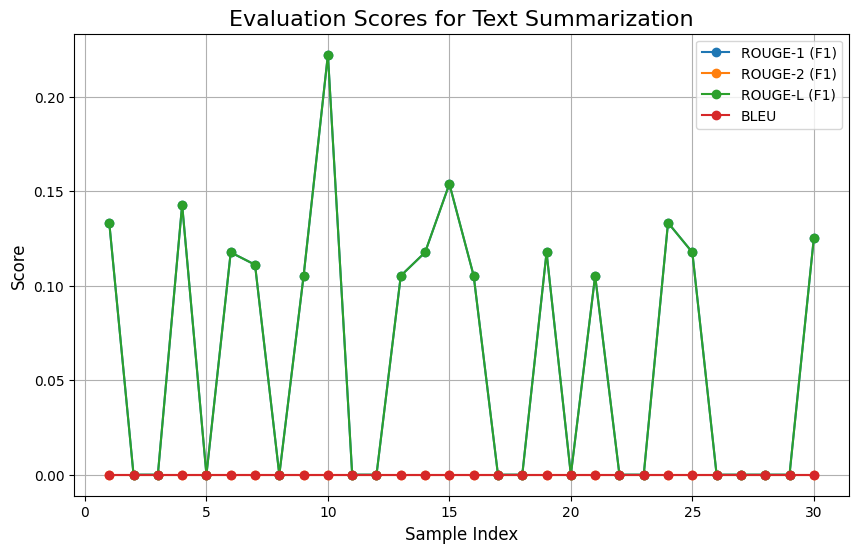

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import matplotlib.pyplot as plt

# Initialize ROUGE
rouge = Rouge()

# To store scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []
bleu_scores = []

# Evaluate for a subset of the data (10 samples as an example)
for i in range(0, 30):
    # print(f"Review {i+1}: {seq2text(x_tr[i])}")
    # print(f"Original summary: {seq2summary(y_tr[i])}")

    # # Get the predicted summary
    # predicted_summary = decode_sequence(x_tr[i].reshape(1, max_text_len))
    # print(f"Predicted summary: {predicted_summary}\n")

    # Calculate ROUGE scores
    rouge_score = rouge.get_scores(predicted_summary, seq2summary(y_tr[i]), avg=True)
    rouge1_scores.append(rouge_score['rouge-1']['f'])
    rouge2_scores.append(rouge_score['rouge-2']['f'])
    rougeL_scores.append(rouge_score['rouge-l']['f'])

    # Calculate BLEU score
    reference = seq2summary(y_tr[i]).split()  # Tokenized reference
    candidate = predicted_summary.split()    # Tokenized candidate
    bleu_score = sentence_bleu([reference], candidate)
    bleu_scores.append(bleu_score)

# Display ROUGE and BLEU scores for each sample
for i in range(30):
    print(f"Sample {i+1}:")
    print(f"ROUGE-1: {rouge1_scores[i]:.2f}, ROUGE-2: {rouge2_scores[i]:.2f}, ROUGE-L: {rougeL_scores[i]:.2f}, BLEU: {bleu_scores[i]:.2f}\n")

# Plot the scores
plt.figure(figsize=(10, 6))

# ROUGE-1
plt.plot(range(1, 31), rouge1_scores, marker='o', label='ROUGE-1 (F1)')
# ROUGE-2
plt.plot(range(1, 31), rouge2_scores, marker='o', label='ROUGE-2 (F1)')
# ROUGE-L
plt.plot(range(1, 31), rougeL_scores, marker='o', label='ROUGE-L (F1)')
# BLEU
plt.plot(range(1, 31), bleu_scores, marker='o', label='BLEU')

plt.title("Evaluation Scores for Text Summarization", fontsize=16)
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Save the full model (Encoder + Decoder combined)
model.save('summarization_model.h5')

# Save individual models if needed
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')


In [ ]:
from tensorflow.keras.models import load_model

# Load the full model
loaded_model = load_model('summarization_model.h5')

# Load individual models
loaded_encoder_model = load_model('encoder_model.h5')
loaded_decoder_model = load_model('decoder_model.h5')


In [ ]:
import pickle

# Save the tokenizers
with open('source_tokenizer.pkl', 'wb') as f:
    pickle.dump(x_tokenizer, f)

with open('target_tokenizer.pkl', 'wb') as f:
    pickle.dump(y_tokenizer, f)




In [ ]:
with open('source_tokenizer.pkl', 'rb') as f:
    source_tokenizer = pickle.load(f)

with open('target_tokenizer.pkl', 'rb') as f:
    target_tokenizer = pickle.load(f)


In [ ]:
# Example input
test_input_seq = x_tr[0].reshape(1, max_text_len)

# Generate the summary
print("Predicted summary:", decode_sequence(test_input_seq))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted summary:  india to be in the world cup


# **Without Attension**

In [ ]:
latent_dim = 300
embedding_dim = 100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Model summary
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 50, 100)        │      3,149,700 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ [(None, 50, 300),      │        481,200 │ embedding_2[0][0]      │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ [(None, 50, 300),      │        721,200 │ lstm_4[0][0]           │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 100)      │      1,106,300 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ [(None, 50, 300),      │        721,200 │ lstm_5[0][0]           │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ [(None, None, 300),    │        481,200 │ embedding_3[0][0],     │
│                           │ (None, 300), (None,    │                │ lstm_6[0][1],          │
│                           │ 300)]                  │                │ lstm_6[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, None, 11063)    │      3,329,963 │ lstm_7[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,990,763 (38.11 MB)

 Trainable params: 9,990,763 (38.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([x_tr, y_tr[:,:-1]],
                  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                  epochs=10,
                  callbacks=[es],
                  batch_size=128,
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
                 )


Epoch 1/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 243s 335ms/step - accuracy: 0.3557 - loss: 5.4253 - val_accuracy: 0.3968 - val_loss: 4.6597
Epoch 2/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 257s 328ms/step - accuracy: 0.3949 - loss: 4.6481 - val_accuracy: 0.4073 - val_loss: 4.4392
Epoch 3/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 261s 327ms/step - accuracy: 0.4067 - loss: 4.3857 - val_accuracy: 0.4193 - val_loss: 4.1551
Epoch 4/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 225s 325ms/step - accuracy: 0.4194 - loss: 4.0874 - val_accuracy: 0.4326 - val_loss: 3.9327
Epoch 5/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 267s 332ms/step - accuracy: 0.4311 - loss: 3.8571 - val_accuracy: 0.4416 - val_loss: 3.7877
Epoch 6/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 256s 323ms/step - accuracy: 0.4408 - loss: 3.6860 - val_accuracy: 0.4498 - val_loss: 3.6781
Epoch 7/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 260s 320ms/step - accuracy: 0.4489 - loss: 3.5459 - val_accuracy: 0.4553 - val_loss: 3.5968
Epoch 8/10
692/692 ━━━━━━━━━━━━━━━━━━━━ 266s 326ms/step - accuracy: 0.4551 -

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        # Include e_out in the input to the decoder_model
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# prompt: efine the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if ((i != 0 and i != target_word_index['sostok']) and i != target_word_index['eostok']):
            newString = newString + reverse_target_word_index[i] + ' '
    return newString


def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if (i != 0):
            newString = newString + reverse_source_word_index[i] + ' '
    return newString

In [ ]:
for i in range(0, 10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")


Review: inflation venezuela new currency introduced three weeks ago hit price cup coffee caracas doubled bolivars since introduction according bloomberg cafe con index president nicol maduro removed five bolivar price new bolivars equal old bolivars 
Original summary: inflation in venezuela week old currency hits 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted summary:  india to be in the world cup


Review: search giant google added new search navigation tab called finance desktop mobile web tab gives easier access financial information related news based users interests also lets users see performance information stocks users choose follow shows recommendations stocks indices follow 


Sample 1:
ROUGE-1: 0.13, ROUGE-2: 0.00, ROUGE-L: 0.13, BLEU: 0.00

Sample 2:
ROUGE-1: 0.00, ROUGE-2: 0.00, ROUGE-L: 0.00, BLEU: 0.00

Sample 3:
ROUGE-1: 0.00, ROUGE-2: 0.00, ROUGE-L: 0.00, BLEU: 0.00

Sample 4:
ROUGE-1: 0.14, ROUGE-2: 0.00, ROUGE-L: 0.14, BLEU: 0.00

Sample 5:
ROUGE-1: 0.00, ROUGE-2: 0.00, ROUGE-L: 0.00, BLEU: 0.00

Sample 6:
ROUGE-1: 0.12, ROUGE-2: 0.00, ROUGE-L: 0.12, BLEU: 0.00

Sample 7:
ROUGE-1: 0.11, ROUGE-2: 0.00, ROUGE-L: 0.11, BLEU: 0.00

Sample 8:
ROUGE-1: 0.00, ROUGE-2: 0.00, ROUGE-L: 0.00, BLEU: 0.00

Sample 9:
ROUGE-1: 0.11, ROUGE-2: 0.00, ROUGE-L: 0.11, BLEU: 0.00

Sample 10:
ROUGE-1: 0.22, ROUGE-2: 0.00, ROUGE-L: 0.22, BLEU: 0.00

Sample 11:
ROUGE-1: 0.00, ROUGE-2: 0.00, ROUGE-L: 0.00, BLEU: 0.00

Sample 12:
ROUGE-1: 0.00, ROUGE-2: 0.00, ROUGE-L: 0.00, BLEU: 0.00

Sample 13:
ROUGE-1: 0.11, ROUGE-2: 0.00, ROUGE-L: 0.11, BLEU: 0.00

Sample 14:
ROUGE-1: 0.12, ROUGE-2: 0.00, ROUGE-L: 0.12, BLEU: 0.00

Sample 15:
ROUGE-1: 0.15, ROUGE-2: 0.00, ROUGE-L: 0.15, B

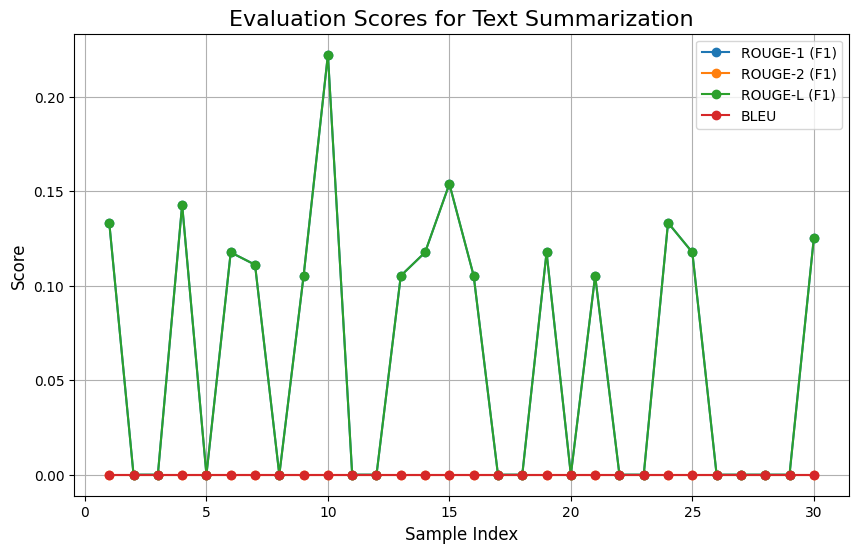

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import matplotlib.pyplot as plt

# Initialize ROUGE
rouge = Rouge()

# To store scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []
bleu_scores = []

# Evaluate for a subset of the data (10 samples as an example)
for i in range(0, 30):
    # print(f"Review {i+1}: {seq2text(x_tr[i])}")
    # print(f"Original summary: {seq2summary(y_tr[i])}")

    # # Get the predicted summary
    # predicted_summary = decode_sequence(x_tr[i].reshape(1, max_text_len))
    # print(f"Predicted summary: {predicted_summary}\n")

    # Calculate ROUGE scores
    rouge_score = rouge.get_scores(predicted_summary, seq2summary(y_tr[i]), avg=True)
    rouge1_scores.append(rouge_score['rouge-1']['f'])
    rouge2_scores.append(rouge_score['rouge-2']['f'])
    rougeL_scores.append(rouge_score['rouge-l']['f'])

    # Calculate BLEU score
    reference = seq2summary(y_tr[i]).split()  # Tokenized reference
    candidate = predicted_summary.split()    # Tokenized candidate
    bleu_score = sentence_bleu([reference], candidate)
    bleu_scores.append(bleu_score)

# Display ROUGE and BLEU scores for each sample
for i in range(30):
    print(f"Sample {i+1}:")
    print(f"ROUGE-1: {rouge1_scores[i]:.2f}, ROUGE-2: {rouge2_scores[i]:.2f}, ROUGE-L: {rougeL_scores[i]:.2f}, BLEU: {bleu_scores[i]:.2f}\n")

# Plot the scores
plt.figure(figsize=(10, 6))

# ROUGE-1
plt.plot(range(1, 31), rouge1_scores, marker='o', label='ROUGE-1 (F1)')
# ROUGE-2
plt.plot(range(1, 31), rouge2_scores, marker='o', label='ROUGE-2 (F1)')
# ROUGE-L
plt.plot(range(1, 31), rougeL_scores, marker='o', label='ROUGE-L (F1)')
# BLEU
plt.plot(range(1, 31), bleu_scores, marker='o', label='BLEU')

plt.title("Evaluation Scores for Text Summarization", fontsize=16)
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend()
plt.grid()
plt.show()


In [ ]:
import pickle

# Save the tokenizers
with open('noattention_source_tokenizer.pkl', 'wb') as f:
    pickle.dump(x_tokenizer, f)

with open('noattention_target_tokenizer.pkl', 'wb') as f:
    pickle.dump(y_tokenizer, f)

# Save the full model (Encoder + Decoder combined)
model.save('noattention_summarization_model.h5')

# Save individual models if needed
encoder_model.save('noattention_encoder_model.h5')
decoder_model.save('noattention_decoder_model.h5')

